In [1]:
from google.colab import drive
drive.mount('/content/Gdrive')
% cd '/content/Gdrive/My Drive/Colab Notebooks/Final'
! ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/Gdrive
/content/Gdrive/My Drive/Colab Notebooks/Final
 auto_encoder_Updated-June142019.h5   model_RFR_06152019.sav
 EvaluationNotebook.ipynb	      model_RFR_final.sav
 Forecasting_Notes.ipynb	      Models
 Forecast_LSTM-June142019.h5	      requirements.txt
 lat_lookup.pickle		     'Traffic Management'
 long_lookup.pickle		      traffic-management.zip


# Pre-requisites

Below are some pre-requisites for the project.

In [2]:
!pip install scipy==1.2

     |████████████████████████████████| 26.6MB 1.2MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.0
    Uninstalling scipy-1.3.0:
      Successfully uninstalled scipy-1.3.0


## Dependencies load

In [3]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation,PillowWriter
import seaborn as sns
import numpy as np
import pickle
import math
import time
from pprint import pprint
from fbprophet import Prophet
from math import log10
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook
from sklearn.ensemble import RandomForestRegressor

from IPython.display import HTML, Image, Math
from google.colab.output._publish import javascript
url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"

javascript(url=url)
Math(r"e^\alpha")

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,10
rcParams['figure.dpi'] = 75
rcParams['agg.path.chunksize'] = 10000
rcParams['animation.html'] = 'html5'
plt.rcParams['axes.facecolor'] = 'white'

pd.set_option('display.max_row', 1000)
pd.set_option('display.max_column', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x) # Just to make some floats easier to look at. Will not change dtype.

## Dataset Fetch

In [5]:
! wget https://s3-ap-southeast-1.amazonaws.com/grab-aiforsea-dataset/traffic-management.zip
! unzip traffic-management.zip

--2019-06-15 14:49:22--  https://s3-ap-southeast-1.amazonaws.com/grab-aiforsea-dataset/traffic-management.zip
Resolving s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)... 52.219.32.5
Connecting to s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)|52.219.32.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62874232 (60M) [application/zip]
Saving to: ‘traffic-management.zip’

traffic-management. 100%[===================>]  59.96M  10.7MB/s    in 7.2s    

2019-06-15 14:49:30 (8.30 MB/s) - ‘traffic-management.zip’ saved [62874232/62874232]

Archive:  traffic-management.zip
  inflating: Traffic Management/training.csv  


## Dataset Load

### For testing

In [4]:
data= pd.read_csv('./Traffic Management/training.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206321 entries, 0 to 4206320
Data columns (total 4 columns):
geohash6     object
day          int64
timestamp    object
demand       float64
dtypes: float64(1), int64(1), object(2)
memory usage: 128.4+ MB


### For Evaluation

I am asuming that the hold-off dataset would have to be loaded up as CSV together with the training set. To ensure that the preprocessing would be applied to all the data I suggest that the test dataset be concatenated before the the preprocessing.

In [0]:
data_1 = pd.read_csv('<insert training data csv file name here>')
data_2 = pd.read_csv('<insert holdoff data csv file name here>')
data = pd.concat([data_1,data_2])

## Miscelaneous and Helper functions

Below are the helper functions created for this project. Could be transferred to a python script file for houskeeping later.

In [53]:
!ls

 auto_encoder_Updated-June142019.h5   model_RFR_06152019.sav
 EvaluationNotebook.ipynb	      model_RFR_final.sav
 Forecasting_Notes.ipynb	      Models
 Forecast_LSTM-June142019.h5	      requirements.txt
 lat_lookup.pickle		     'Traffic Management'
 long_lookup.pickle		      traffic-management.zip


In [0]:
# Helper Functions
# Basic RMS function.

def RMS(pred_val, true_val):
    return math.sqrt(((true_val-pred_val)**2).mean())

def sklearn_RMS(pred_val, true_val):
    from sklearn.metrics import mean_squared_error
    return (mean_squared_error(true_val, pred_val))**0.5

## Preprocessing Functions
def get_time(data):
    hour = []
    minute = []
    for item in data['timestamp']:
        hour.append(item.rsplit(sep=':')[0])
        minute.append(item.rsplit(sep=':')[1])
    data['hour'] = hour
    data['minute'] = minute
    data.hour = pd.to_numeric(data.hour, errors = 'coerce').astype(np.int16)
    data.minute = pd.to_numeric(data.minute, errors = 'coerce').astype(np.int16)

    return data

def data_add_year(data):
    data['year'] = 2019 # Arbitrary year
    return data

def add_mnth(data):
    '''
    Adding arbitrary date, just to make it easier for datetime conversion and arrange the data
    '''
    month=[]
    for item in data['day']:
        if item <= 31:
            month.append(3) # March 2019
        elif item >31 & item <=61:
            month.append(4) # April 2019
        else:
            month.append(5) # May 2019 (Arbitrary). This would fail the `days` value gets past the days for May 2019.
    data['month'] = month
    return data

def add_mnth_day(data):
    mnth_day = []
    for item in data['day']:
        if item > 61:
            day = item%61
        else:
            day=item
        mnth_day.append((day)%31)
    data['mnth_day'] = mnth_day
    data.loc[data['mnth_day']==0, 'mnth_day']=31 # Fixing days that will be 0 instead of 31
    return data

def check_day(data):
    '''
    Checking the day of the week based on the value of day_index
    Do note that this is also arbitrary since I do not know when exactly the timeframe started.
    Adding this since there must be some factor of the time of date and I would like for my regressor to figure it out if possible.
    '''
    lookup = {1:1,2:2,3:3,4:4,5:5,6:6,0:7}
    dow = []
    for item in data['day']:
        dow.append(lookup.get(item%7))
    data['dow'] = dow
    return data

def add_stamp(data):
    data['date'] = pd.to_datetime({'day':data.mnth_day,
                               'month':data.month,
                               'year':data.year,
                               'hour':data.hour,
                               'minute':data.minute                              
                              })
    data['date']=pd.to_datetime(data.date,format='%Y-%m-%d-%H:%M')
    return data

def lat_long_lookup(data):
    '''
    Decoding the latitude and longitude the individual Geohash codes.
    Via Lookup table
    '''
    lat_lookup = pickle.load(open('lat_lookup.pickle','rb'))
    long_lookup = pickle.load(open('long_lookup.pickle','rb'))
    lat = []
    long = []
    for item in data['geohash6']:
        lat.append(lat_lookup.get(item))
        long.append(long_lookup.get(item))
    data['lat_lookup'] = lat
    data['long_lookup'] = long
    return data

def geohash_encode_lookup(data):
    from sklearn.preprocessing import LabelEncoder
    geo_encoder = LabelEncoder()
    
    data['geo_encoded']=geo_encoder.fit_transform(data['geohash6'])
    return data

## Apply Preprocessing

def data_process(data):
    data = get_time(data)
    data = data_add_year(data)
    data = add_mnth(data)
    data = add_mnth_day(data)
    data = check_day(data)
    data = add_stamp(data)
    data = lat_long_lookup(data)
    data = geohash_encode_lookup(data)
    data.sort_values(by=['date'], inplace=True)
    data.reset_index(inplace=True)
    data.drop('index',inplace=True, axis=1)
    return data

## Pivot and fill data

def fill_missing(data):
    pivot = data.pivot_table(index= 'date', columns='geohash6', values='demand', fill_value=0)
    pivot.sort_values(by=['date'], inplace=True)
    full_date = pd.date_range(start=data['date'].min(), end= data['date'].max(), freq='15T')
    dates_list = list(set(data['date']))
    missing = []
    for item in full_date:
        if item not in dates_list:
            missing.append(item)
    print('Missing entries:',len(missing))
    print(missing)
    print('Pivot Table Entries: {}\nExpected Date Entries: {}\nMissing Date count: {}'.format(len(pivot),len(full_date),(len(full_date)-len(pivot))))
    upsample = pivot.resample('15T').interpolate(method='linear').reset_index()
    upsample.set_index('date',inplace=True)
    print('Missing dates filled ... ')
    return upsample

## Create masking dataframe

def create_mask(upsample):
    mask_ = pd.DataFrame(np.where((upsample)>0,1,(upsample)))
    return mask_

## Load Autoencoder module

def load_model_autoencoder():
    from keras.layers import Dense, Input, Dropout
    from keras.models import Model
    from keras.models import load_model
    auto_encoder = load_model('auto_encoder_Updated-June142019.h5')
    auto_encoder.summary()
    encoder = Model(auto_encoder.input,auto_encoder.layers[-10].output)
    encoder.summary()
    decoder_input = Input(shape=(1,))
    decoded = auto_encoder.layers[-9](decoder_input)
    decoded = auto_encoder.layers[-8](decoded)
    decoded = auto_encoder.layers[-7](decoded)
    decoded = auto_encoder.layers[-6](decoded)
    decoded = auto_encoder.layers[-5](decoded)
    decoded = auto_encoder.layers[-4](decoded)
    decoded = auto_encoder.layers[-3](decoded)
    decoded = auto_encoder.layers[-2](decoded)
    decoded = auto_encoder.layers[-1](decoded)

    decoder=Model(decoder_input,decoded)
    decoder.summary()
    return auto_encoder,encoder,decoder

## Create Encoded Data

def encode_data(upsample,encoder_2):
    encoded_2 = encoder_2.predict(upsample.values[:])
    encoded_data_2 = pd.DataFrame(index = upsample.index, columns=['encoded'])
    encoded_data_2['encoded'] = encoded_2
    print('Maximum Encoded data: {}\nMinimum Encoded data: {}'.format(encoded_data_2.max(),encoded_data_2.min()))
    encoded_data_2=encoded_data_2.astype({'encoded':np.float64})
    return  encoded_data_2

# ## LSTM Test Train Data

# def create_test_train_lstm(dataset,current,walk_forward,f_step):
#     from tqdm import tqdm_notebook
#     X_train, y_train = [], []
#     for i in tqdm_notebook(range(walk_forward-f_step)):
#         X_train.append(dataset.values[-(lookback+current)+i:-(current)+i])
#         y_train.append(dataset.values[-(current)+i:-(current)+i+f_step])
#     print('Training Set Created')
#     return X_train,y_train

## Walk forward LSTM using Preds
def LSTM_WALK_preds(dataset,lookback,current,walk_forward,f_step):
    '''
    Makes the forward walk for the LSTM Model
    '''   

    X_train = np.array(dataset.values[-(lookback+current):-(current)]).reshape(1,lookback,1)
    from tqdm import tqdm_notebook
    import keras
    from keras.layers import Dense, Input, Dropout, LSTM,LeakyReLU
    from keras.models import Sequential
    from keras.models import load_model
    Forecast_LSTM = load_model('Forecast_LSTM-June142019.h5')
    # Forecast_LSTM.summary()
    true = dataset[-(current):-(current-walk_forward)]
    y_hat_LSTM = []
    predictions = Forecast_LSTM.predict(X_train)
    for i in range(walk_forward):
        predictions = Forecast_LSTM.predict(X_train)
        y_hat = predictions[i]
        y_hat_LSTM.append(predictions[i][0])
        X_train = np.append(X_train,predictions[i][0])
        X_train = np.delete(X_train,0,axis=0)        
        X_train = X_train.reshape(1,lookback,1)
        
    LSTM_Res = pd.DataFrame(columns= ['true','preds'])
    LSTM_Res['true'] = true
    LSTM_Res['preds'] = y_hat_LSTM
    return LSTM_Res, y_hat

def WALK_ARIMA(dataset, lookback = 1344,current=500, walk_point = 1, f_steps = 5):

    '''
    INPUTS:
    
    dataset = The encoded data to be used.
    parameters = The combination of Parameters based on get_params_list
    lookback = *Window Size*, number of sequences considered for fitting the model. Defaults to 1300 (approx. 13.5 days)
    current = Pointer of the start of the testing
    stop_point = Number of predictions to get.
    f_steps = Number of sequences to forecast per prediction
    
    OUTPUTS:
    Final_results = Log of the Gridsearch for ARIMA Model
    model = best model found via gridsearch
    y_hat = list of forecasts using the best model
    score = RMS score for the forecasted values
    forecast_frame = Log of the true and forecasted value based on the best model
    forecast_best = Complete result of forecasts from the model. Includes Errors
    '''
    import warnings
    warnings.filterwarnings("ignore")
    from statsmodels.tsa.arima_model import ARIMA
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from tqdm import tqdm_notebook
    import time

    window = dataset.values[-(lookback+current):-(current)]
    Series = dataset.values
    results = []
    logs = []
    true_list = []
    moving_window = [x for x in window]
    running_score = []
    for i in tqdm_notebook(range(walk_point)): # This will fit and update when a new data becomes available.
#     for i in tqdm_notebook(range(0,walk_point,5)): # This will fit and update every 5 timesteps.
        try:
            # Try to fit the window to SARIMA
            model = SARIMAX(moving_window, order = (0,0,0), seasonal_order= (1,0,0,0), trend='c', enforce_stationarity=False, enforce_invertibility=False).fit()
            forecast_best = model.forecast(steps=f_steps)
            y_hat = forecast_best.tolist()
            used = 'Sarima'
        except:
            # If the SARIMA is invalid for the window use ARIMA
            model = ARIMA(moving_window, order = (1,0,0)).fit()
            forecast_best = model.forecast(steps=f_steps)
            y_hat = forecast_best[0].tolist()
            used = 'Arima'
        results.append(y_hat[0])
#         moving_window.append(y_hat[0]) ## Uncomment this if we are going to use the Predicted Values as input.
        moving_window.append(Series[-current+i])
        moving_window = moving_window[1:] ## Using the True value for use on the next target.
        logs.append(y_hat)
        true_list.append(Series[-current+i])
        forecast_frame = pd.DataFrame(columns = ['preds','true','scores'])
        forecast_frame['preds'] = results
        forecast_frame['true'] = true_list
        score=RMS(forecast_frame['preds'],forecast_frame['true'])
        running_score.append(score)
#         print('Using: {}\t RMS: {}'.format(used,score))
    forecast_frame['scores'] = running_score
    print('Walk forward Completed!')
    return forecast_frame,logs, y_hat

## Model Score
def get_score(forecast_frame,current,walk_point):
    decoded_SARIMA = decoder_2.predict(forecast_frame)# note:  using decoder 2
    actual_SARIMA = upsample[-current:(-current+walk_point)] # - current : -current + f_steps
    mask_SARIMA = mask_[-current:(-current+walk_point)] # - current : -current + f_steps
    masked_SARIMA = pd.DataFrame(decoded_SARIMA*mask_SARIMA,columns=upsample.columns)
    model_score = RMS(masked_SARIMA.values,actual_SARIMA.values)
    print('Full Decoded Model Score: ',model_score)
    return model_score

def final_five_score(dataset,y_hat_last,current,walk_point,f_steps):
    final_five = pd.DataFrame(columns = ['preds','true'])
    final_five['preds'] = y_hat_last
    final_five['true'] = dataset.values[(-current+walk_point):(-current+walk_point+f_steps)]
    score=RMS(final_five['preds'],final_five['true'])
    print('Encoded Preds Score:',score)
    decoded_SARIMA = decoder_2.predict(final_five['preds'])# note:  using decoder 2
    actual_SARIMA = upsample[(-current+walk_point):(-current+walk_point+f_steps)] # - current : -current + f_steps
    mask_SARIMA = mask_[(-current+walk_point):(-current+walk_point+f_steps)] # - current : -current + f_steps
    masked_SARIMA = pd.DataFrame(decoded_SARIMA*mask_SARIMA,columns=upsample.columns)
    decoded_model_score = RMS(masked_SARIMA.values,actual_SARIMA.values)
    print('Final Five Model Score: ',decoded_model_score)
    return score,decoded_model_score

def load_RFR_model():
    filename = 'model_RFR_final.sav'
    model_RFR = pickle.load(open(filename, 'rb'))
    return model_RFR   

def Ensemble_all(SARIMA_Train,LSTM_Train,model_LSTM,model_ens):
    model = SARIMAX(SARIMA_Train, order = (0,0,0), seasonal_order= (1,0,0,0), trend='c', enforce_stationarity=False, enforce_invertibility=False).fit()
    forecast_best = model.forecast(steps=5)
    y_hat_ARIMA = forecast_best.tolist()
    y_hat_LSTM = model_LSTM.predict(LSTM_Train)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    ensemble = pd.DataFrame(columns = ['SARIMA','LSTM', 'SARIMA_UP','SARIMA_LOW','LSTM_UP','LSTM_LOW','POS'])
    pos = []
    for item in range(len(y_hat_LSTM)):
        pos.append(item%5)
    ensemble['POS'] = pos
    ensemble['true'] = true
    ensemble['SARIMA'] = y_hat_SARIMA
    ensemble['LSTM'] = y_hat_LSTM
    ensemble['LSTM_UP'] = ensemble['LSTM']*1.05
    ensemble['LSTM_LOW'] = ensemble['LSTM']*0.95
    ensemble['SARIMA_UP'] = ensemble['SARIMA']*1.05
    ensemble['SARIMA_LOW'] = ensemble['SARIMA']*0.95
    ensemble['POS']=scaler.fit_transform(ensemble['POS'].values.reshape(-1,1))
    step_encoded = model_ens.predict(ensemble)
    return step_encoded

def ensemble_frame(true,y_hat_SARIMA,y_hat_LSTM):
    '''
    Creates a DataFrame that will be used for Ensemble input
    '''
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    ensemble = pd.DataFrame(columns = ['true','SARIMA','LSTM', 'SARIMA_UP','SARIMA_LOW','LSTM_UP','LSTM_LOW','POS'])
#     ensemble = pd.DataFrame(columns = ['true','SARIMA','LSTM','POS'])
    pos = []
    for item in range(len(true)):
        pos.append(item%5)
    
    ensemble['POS'] = pos
    ensemble['true'] = true
    ensemble['SARIMA'] = y_hat_SARIMA
    ensemble['LSTM'] = y_hat_LSTM
    ensemble['LSTM_UP'] = ensemble['LSTM']*1.05
    ensemble['LSTM_LOW'] = ensemble['LSTM']*0.95
    ensemble['SARIMA_UP'] = ensemble['SARIMA']*1.05
    ensemble['SARIMA_LOW'] = ensemble['SARIMA']*0.95
    ensemble['POS']=scaler.fit_transform(ensemble['POS'].values.reshape(-1,1))

    return ensemble

def create_test_train_lstm(dataset,current,walk_forward,f_step):
    from tqdm import tqdm_notebook
    
    X_train, y_train = [], []
    # for i in tqdm_notebook(range(walk_forward-f_step)): # Will not include last f_steps
#     for i in tqdm_notebook(range(walk_forward)):
    for i in range(walk_forward):
        X_train.append(np.array(dataset.values[-(lookback+current)+i:-(current)+i]).reshape(lookback,1))
        y_train.append(np.array(dataset.values[-(current)+i:-(current)+i+f_step]))
#     print('Training Set Created')
    return np.array(X_train),np.array(y_train)

def LSTM_WALK(model,dataset,lookback,current,walk_forward,f_step):
    '''
    Makes the forward walk for the LSTM Model
    '''   

    X_train,y_train = create_test_train_lstm(dataset=dataset,current=current,walk_forward=walk_forward,f_step=f_step)
    from tqdm import tqdm_notebook
    true = dataset[-(current):-(current-walk_forward)]
    y_hat_LSTM = []
    y_hat_hist = []
    predictions = model.predict(X_train)
    for i in range(walk_forward):
        y_hat = predictions[i]
        y_hat_LSTM.append(predictions[i][0])
        y_hat = y_hat.tolist()
        y_hat_hist=y_hat_hist+y_hat
    LSTM_Res = pd.DataFrame(columns= ['true','preds'])
    LSTM_Res['true'] = true
    LSTM_Res['preds'] = y_hat_LSTM
    return LSTM_Res, y_hat,y_hat_hist

def WALK_SARIMA(dataset, lookback = 1344,current=500, walk_point = 1, f_steps = 5):

    '''
    INPUTS:
    
    dataset = The encoded data to be used.
    parameters = The combination of Parameters based on get_params_list
    lookback = *Window Size*, number of sequences considered for fitting the model. Defaults to 1300 (approx. 13.5 days)
    current = Pointer of the start of the testing
    stop_point = Number of predictions to get.
    f_steps = Number of sequences to forecast per prediction
    
    OUTPUTS:
    Final_results = Log of the Gridsearch for ARIMA Model
    model = best model found via gridsearch
    y_hat = list of forecasts using the best model
    score = RMS score for the forecasted values
    forecast_frame = Log of the true and forecasted value based on the best model
    forecast_best = Complete result of forecasts from the model. Includes Errors
    '''
    import warnings
    warnings.filterwarnings("ignore")
    from statsmodels.tsa.arima_model import ARIMA
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from tqdm import tqdm_notebook
    import time

    window = dataset.values[-(lookback+current):-(current)]
    Series = dataset.values
    results = []
    logs = []
    true_list = []
    moving_window = [x for x in window]
    running_score = []
    for i in range(walk_point):
#     for i in tqdm_notebook(range(walk_point)): # This will fit and update when a new data becomes available.
#     for i in tqdm_notebook(range(0,walk_point,5)): # This will fit and update every 5 timesteps.
        try:
            # Try to fit the window to SARIMA
            model = SARIMAX(moving_window, order = (0,0,0), seasonal_order= (1,0,0,0), trend='c', enforce_stationarity=False, enforce_invertibility=False).fit()
            forecast_best = model.forecast(steps=f_steps)
            y_hat = forecast_best.tolist()
            logs=logs+y_hat
            used = 'Sarima'
        except:
            # If the SARIMA is invalid for the window use ARIMA
            model = ARIMA(moving_window, order = (1,0,0)).fit()
            forecast_best = model.forecast(steps=f_steps)
            y_hat = forecast_best[0].tolist()
            logs=logs+y_hat
            used = 'Arima'
        results.append(y_hat[0])
#         moving_window.append(y_hat[0]) ## Uncomment this if we are going to use the Predicted Values as input.
        moving_window.append(Series[-current+i])
        moving_window = moving_window[1:] ## Using the True value for use on the next target.
        true_list.append(Series[-current+i])
        forecast_frame = pd.DataFrame(columns = ['preds','true','scores'])
        forecast_frame['preds'] = results
        forecast_frame['true'] = true_list
        score=RMS(forecast_frame['preds'],forecast_frame['true'])
        running_score.append(score)
#         print('Using: {}\t RMS: {}'.format(used,score))
    forecast_frame['scores'] = running_score
#     print('Walk forward Completed!')
    return forecast_frame,logs, y_hat

def get_true(dataset,current,f_step, walk_forward):
    '''
    Returns true values for the sequence t+1 to t+5
    '''
    true_hist=[]
    for i in range(walk_forward):
        true = dataset.values[-(current)+i:-(current)+f_step+i]
        true_hist = true_hist+true.tolist()
#     if -(current)+f_step==0:
#         true = dataset.values[-current:]
#     else:
#         true = dataset.values[-(current):-(current)+f_step]
    return true_hist

# Data Processing

Adding features and preparing the data for input to the models.

## Add Features

In [6]:
%%time
data = data_process(data)

CPU times: user 26.9 s, sys: 1.51 s, total: 28.4 s
Wall time: 28.8 s


## Data Pivot and Fill

The `fill_missing` function will create a new table that is a pivot_table from the original data. This new table is arranged by date and by geohash6 location.

Since this is framed as a time series problem I have to ensure continuity of my timesteps so missing dates would also get filled by `fill_missing`

In [7]:
%%time
upsample = fill_missing(data)

Missing entries: 9
[Timestamp('2019-03-18 09:45:00', freq='15T'), Timestamp('2019-03-18 10:00:00', freq='15T'), Timestamp('2019-03-18 10:15:00', freq='15T'), Timestamp('2019-03-18 11:30:00', freq='15T'), Timestamp('2019-03-18 11:45:00', freq='15T'), Timestamp('2019-03-18 12:00:00', freq='15T'), Timestamp('2019-03-18 12:15:00', freq='15T'), Timestamp('2019-03-18 12:30:00', freq='15T'), Timestamp('2019-03-18 12:45:00', freq='15T')]
Pivot Table Entries: 5847
Expected Date Entries: 5856
Missing Date count: 9
Missing dates filled ... 
CPU times: user 17.6 s, sys: 68.2 ms, total: 17.6 s
Wall time: 17.6 s


In [9]:
upsample.shape

(5856, 1329)

## Creating Masking Frames

This is an additional step that I added due to my use of an autoencoder. This is to ensure that I am only getting RMS values on geohashes that actually has values based on the dataset provided and disregard decoded demand that was not originally in the data.

**NOTE**: This is one of the reasons why I need to make sure that the data from the end of the training dataset until the last data of the holdoff dataset are continous and concatenated. Without the concatenation the masking will not be effective.

In [0]:
mask_ =  create_mask(upsample)

# Autoencoder Loading

This section loads the autoencoder, encoder and decoder sections for use.

In [11]:
auto_encoder_2, encoder_2, decoder_2 = load_model_autoencoder()

Using TensorFlow backend.
W0616 04:11:23.220235 140442891171712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0616 04:11:23.287545 140442891171712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0616 04:11:23.332610 140442891171712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0616 04:11:23.333895 140442891171712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_de

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 1329)              0         
_________________________________________________________________
enc_1 (Dense)                (None, 512)               680960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
enc_2 (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
enc_3 (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

# Encoding the Data

The last step we have done to the data was pivot and fill its missing dates. That data is now ready to be encoded into the autoencoder so that we can frame the problem as univariate.

The `encoded_data_2` is a dataframe that contains the encoded representation of the demand data that we have. From $\ (4206321, 14)$rows we now have a $\ (5856,1)$ or whatever total number of sequences would be between day 0 and the final predicition date. It should now be easier to work with this data form instead of the huge data we originally had.

In [12]:
encoded_data_2 = encode_data(upsample,encoder_2)

Maximum Encoded data: encoded    7.058011
dtype: float32
Minimum Encoded data: encoded   -0.616193
dtype: float32


# EDA

Now that we have encoded the data we can do some basic exploration on the data set to see what insights we can gain from it that can help find solutions to our problem which is Traffic Management in SEA.

## Temporal Analysis

Analysis of the time component of the data.

### FB Prophet

In [13]:
prophet= data.loc[data['geohash6']=='qp09sw']
prophet.drop(['geohash6','day','timestamp','lat_lookup','long_lookup','hour','minute','year','month','mnth_day','dow','geo_encoded'],inplace=True,axis = 1)
prophet = prophet.rename(columns={'demand':'y','date':'ds'})
prophet = prophet[['ds','y']]
train_set = prophet.loc[prophet['ds']<'2019-04-15-00:00']
t_set = prophet.loc[prophet['ds']>'2019-04-15-00:00']
print('Train Set = {}\nTest Set = {}'.format(train_set.shape, t_set.shape))
model = Prophet()
model.fit(train_set)
future = t_set
forecast = model.predict(future)
forecast['y_true'] = future['y'].values
rms_score = RMS(forecast['y_true'],forecast['yhat'])
print('RMS Score for Prophet: {}'.format(rms_score))

I0616 04:11:26.955555 140442891171712 forecaster.py:886] Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Train Set = (3925, 2)
Test Set = (1427, 2)
RMS Score for Prophet: 0.060920327020638286


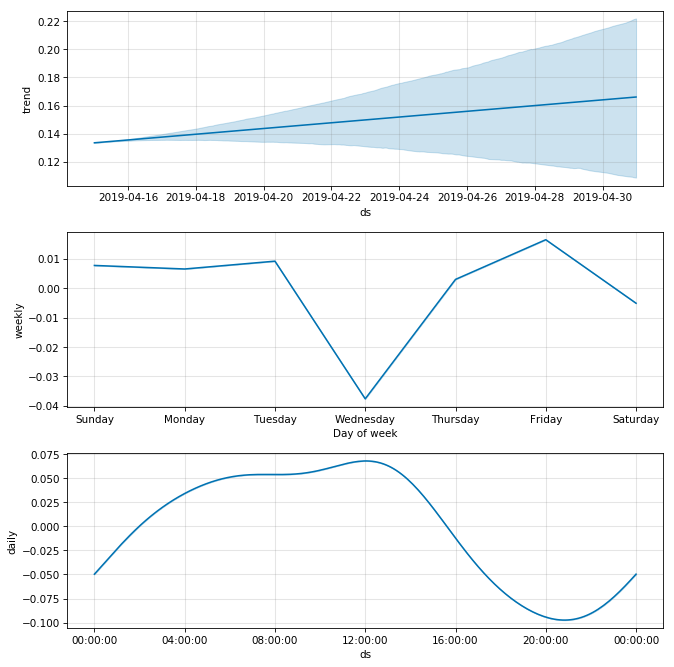

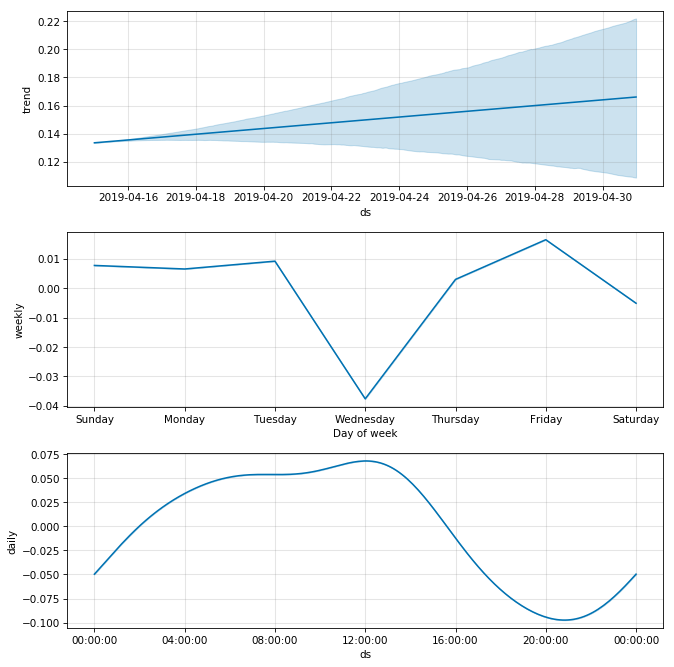

In [14]:
model.plot_components(forecast)

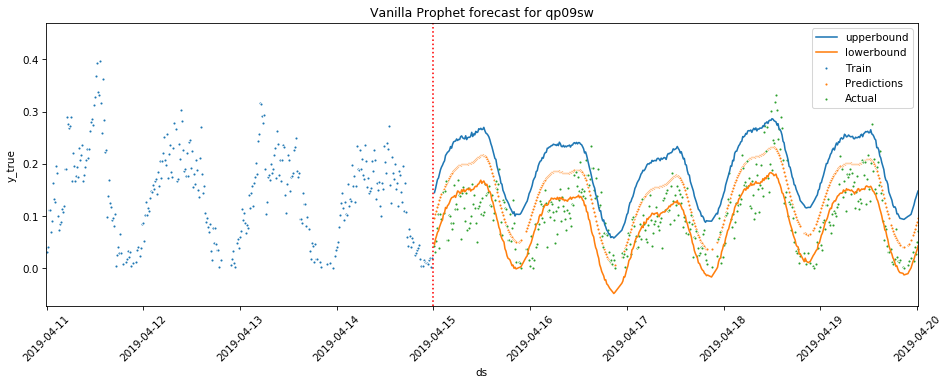

In [15]:
fig, ax = plt.subplots(figsize=(15,5), dpi=75)
# Saving data/notebook size. For better plot, Comment out the line above and uncomment the one below.
# fig, ax = plt.subplots(figsize=(100,10), dpi=100)
# Adding date and demand
# Train Set
ax = sns.scatterplot(x=train_set['ds'],y=train_set['y'],label = 'Train', s=8)
# ax = sns.lineplot(x=train_set['ds'], y=train_set['y'], label='Train', markersize=8) # uncomment this line if you prefer the lineplot, Make sure to comment out scatter.
# Forecast Set
ax = sns.scatterplot(x=forecast['ds'], y=forecast['yhat'], label='Predictions', s=8) # Predictions
ax = sns.lineplot(x=forecast['ds'], y=forecast['yhat_upper'], label='upperbound', markersize=8) # Upper Confidence level
ax = sns.lineplot(x=forecast['ds'], y=forecast['yhat_lower'], label='lowerbound', markersize=8) # Lower Confidence Level
ax = sns.scatterplot(x=forecast['ds'], y=forecast['y_true'], label='Actual', s=8)
# ax = sns.lineplot(x=forecast['ds'], y=forecast['y_true'], label='Actual', markersize=8) # uncomment this line if you prefer the lineplot, Make sure to comment out scatter.

# Test Train separator
plt.axvline(linestyle='dotted', color='r',x=pd.to_datetime('2019-04-15 00:00:00'))

# Date Bounds: To focus more on the test train transition. Feel free to set it to 2019-02-28 and 2019-05-01 for the full dataset run.
ax.set_xlim([pd.to_datetime('2019-04-10 23:50:00'), pd.to_datetime('2019-04-20 00:10:00')])
ax.set_title('Vanilla Prophet forecast for qp09sw')
# Rotate the dates
for item in ax.get_xticklabels():
    item.set_rotation(45)

### Autocorrelation, PACF and ACF Plots

<Figure size 800x560 with 0 Axes>

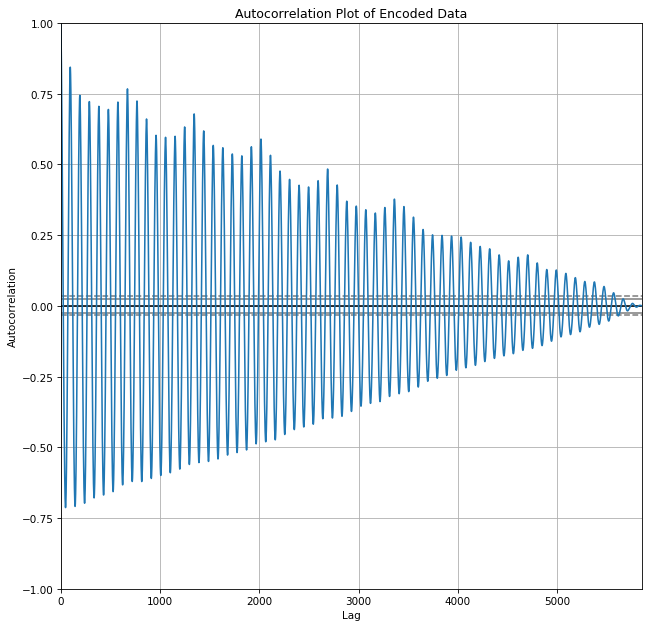

<Figure size 800x560 with 0 Axes>

In [16]:
from pandas.plotting import autocorrelation_plot

series = encoded_data_2['encoded'].values
autocorrelation_plot(series)
plt.title('Autocorrelation Plot of Encoded Data')
plt.figure(figsize=(10, 7), dpi=80)

Seasonal Decomposition Hourly time-Frame


<Figure size 750x750 with 0 Axes>

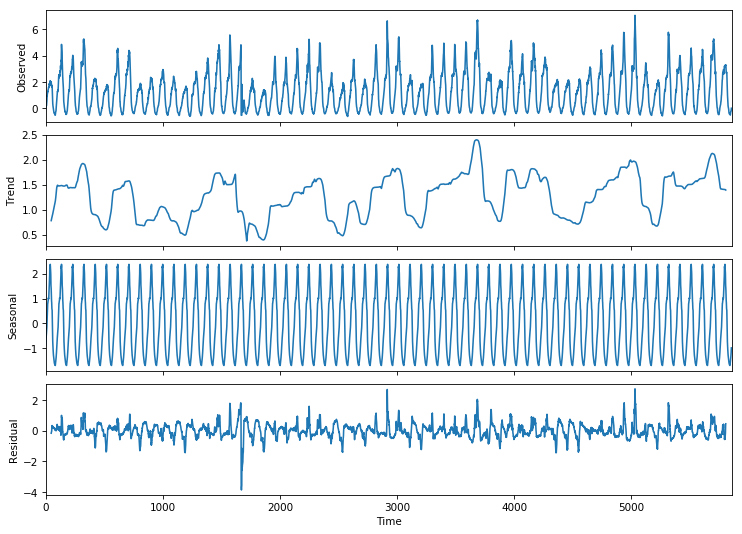

In [18]:
# Source: https://www.kaggle.com/aless80/sarimax-on-mean-visits
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series, freq=96)  # If I understand it correctly, the frequency is daily. 4 (15-minute buckets) x 24 hours = 96
fig = plt.figure()  
fig = decomposition.plot()
fig.set_size_inches(10, 7)
print('Seasonal Decomposition Hourly time-Frame')

Seasonal Decomposition Weekly time-Frame


<Figure size 750x750 with 0 Axes>

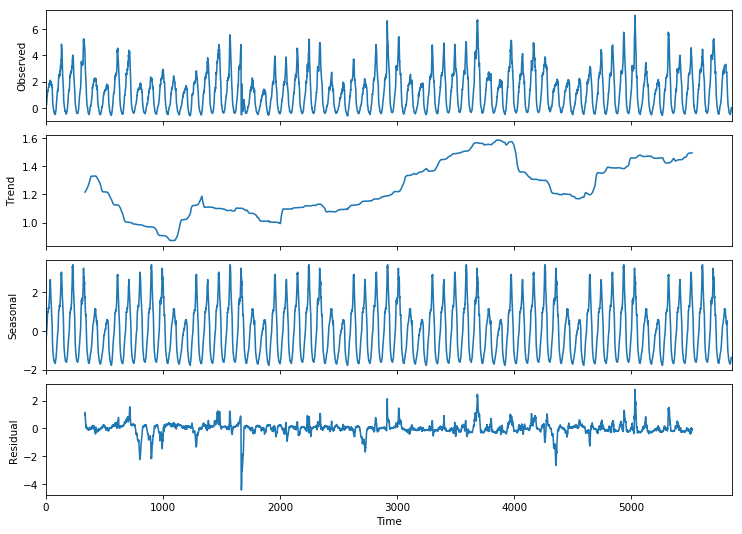

In [19]:
decomposition = seasonal_decompose(series, freq=(96*7))  # If I understand it correctly, the frequency is daily. 4 (15-minute buckets) x 24 hours = 96 * 7 days per week.
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(10, 7)
print('Seasonal Decomposition Weekly time-Frame')

ACF and PACF of the Encoded Data


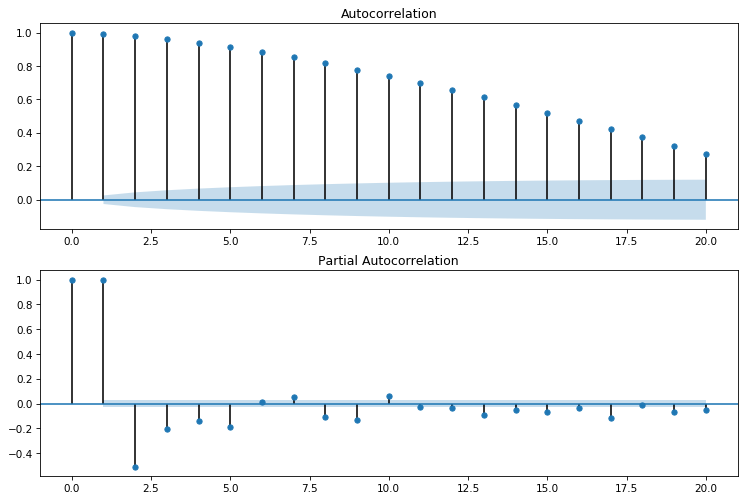

In [20]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series, lags=20, alpha=.05, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series, lags=20, alpha=.05, ax=ax2)
print("ACF and PACF of the Encoded Data")

## Spatial Analysis - Heatmap Generation



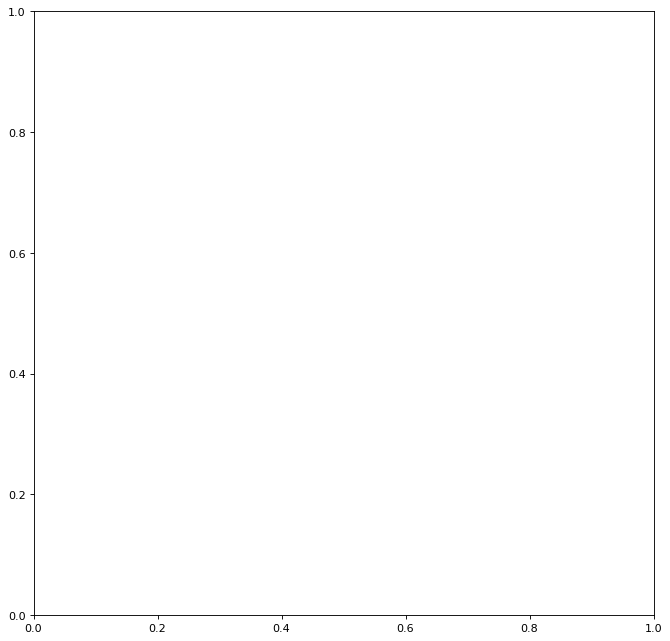

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML, Image
rc('animation', html='html5')
full_date = pd.date_range(start=data['date'].min(), end= data['date'].max(), freq='15T')

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(10,10),dpi=80)
# plt.rcParams['axes.facecolor'] = 'black'


# animation function. This is called sequentially
def update(i):
    import time
    start = time.time()
    date = full_date[i]
    long_ = []
    lat_ = []
    demand_ = []
    
    for row in data.loc[data['date']==date].itertuples():
        long_.append(row.long_lookup)
        lat_.append(row.lat_lookup)
        demand_.append(row.demand)

    # Create Dataframe
    
    holder = pd.DataFrame({'long':long_,'lat':lat_,'demand':demand_})
    
    # Plot the data
    
    hexlayer = ax.hexbin(x=holder['long'],y=holder['lat'],C=holder['demand'], gridsize=30, cmap='afmhot', extent=[90.6,91.0,-5.5,-5.25])
    
    ax.set_title(date)
    ax.set_facecolor('black')
#     print('sample: {} of {} ---- {}'.format(i,len(full_date),time.time()-start))
    return hexlayer,

In [22]:
anim = animation.FuncAnimation(fig, update,
                               frames=range(2000,2050, 1), interval=200)

anim

I0616 04:17:38.727308 140442891171712 animation.py:1146] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
I0616 04:17:38.730507 140442891171712 animation.py:350] MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '800x800', '-pix_fmt', 'rgba', '-r', '5.0', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpshdro3p1/temp.m4v']


## Findings

### Underserved Regions

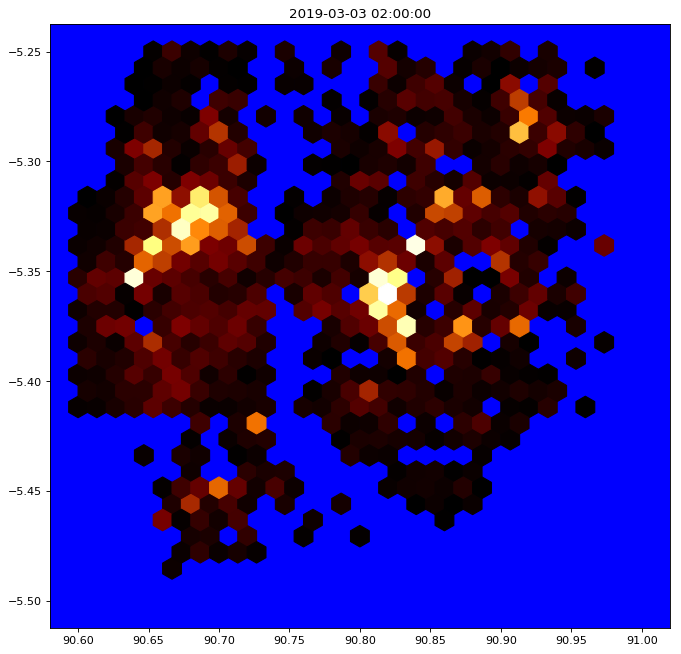

In [23]:
fig, ax = plt.subplots(figsize=(10,10),dpi=80)

i = 200
date = full_date[i]
long_ = []
lat_ = []
demand_ = []

for row in data.loc[data['date']==date].itertuples():
    long_.append(row.long_lookup)
    lat_.append(row.lat_lookup)
    demand_.append(row.demand)
# Create Dataframe

holder = pd.DataFrame({'long':long_,'lat':lat_,'demand':demand_})

# Plot the data

hexlayer = ax.hexbin(x=holder['long'],y=holder['lat'],C=holder['demand'], gridsize=30, cmap='afmhot', extent=[90.6,91.0,-5.5,-5.25])

ax.set_title(date)
ax.set_facecolor('blue')

### High Demand Regions

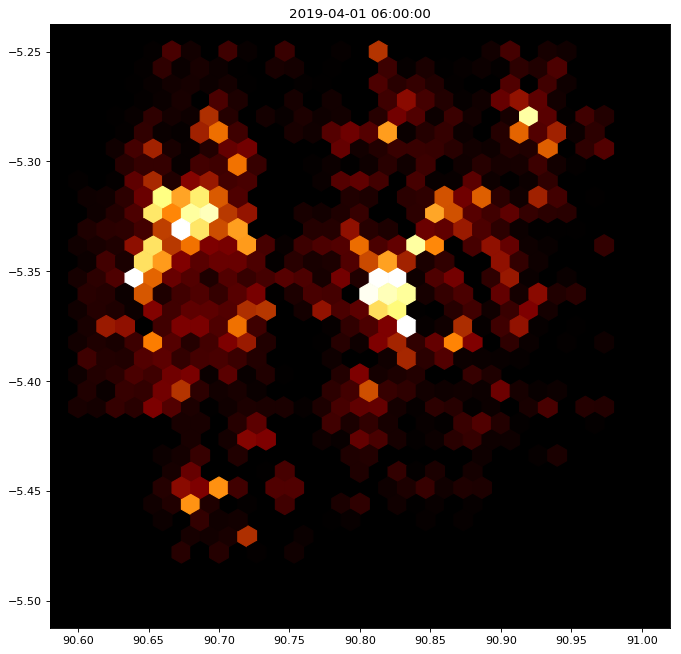

In [24]:
fig, ax = plt.subplots(figsize=(10,10),dpi=80)

i = (3000)
date = full_date[i]
long_ = []
lat_ = []
demand_ = []

for row in data.loc[data['date']==date].itertuples():
    long_.append(row.long_lookup)
    lat_.append(row.lat_lookup)
    demand_.append(row.demand)
# Create Dataframe

holder = pd.DataFrame({'long':long_,'lat':lat_,'demand':demand_})

# Plot the data

hexlayer = ax.hexbin(x=holder['long'],y=holder['lat'],C=holder['demand'], gridsize=30, cmap='afmhot', extent=[90.6,91.0,-5.5,-5.25])

ax.set_title(date)
ax.set_facecolor('black')


# Forecasting Model

**Scenarios**
* **Walk-forward scenario** - Where in the model has to go towards date *t* and provide the forecast for times $(t+1) ... (t+5)$.<br>
    * Assumption: The data between day 61 until time t within which the next 5 predictions of the data is included in the holdout dataset. In short, the **True** demand values between day 61 and day *t* is available for reference.<br>Its important for the data to be provided so that the models can *walk-forward* towards the desired date *t* where the final 5 forecasts are to be retrieved.
* **One-shot scenario** - Where in the model is assumed to be at date *t* and will only have to forecast for times $(t+1) ... (t+5)$.<br>
    * Assumption: The data 14-days prior to date *t* is available. In this case, at least 25 points prior to date *t*.

## LSTM

### Loading the LSTM model

In [0]:
def load_LSTM():
    import keras
    from keras.layers import Dense, Input, Dropout, LSTM,LeakyReLU
    from keras.models import Sequential
    from keras.models import load_model
    Forecast_LSTM = load_model('Forecast_LSTM-June142019.h5')
    return Forecast_LSTM

In [26]:
Forecast_LSTM = load_LSTM()

W0616 04:18:13.796764 140442891171712 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## SARIMA

## Ensemble

In [33]:
%%time
model_RFR = load_RFR_model()

CPU times: user 32.9 ms, sys: 32 ms, total: 64.9 ms
Wall time: 466 ms


In [51]:
for i in range(len(model_RFR.feature_importances_)):
    print(model_RFR.feature_importances_[i],ensemble.drop('true',axis=1).columns[i])

0.05922411386898257 SARIMA
0.29922722858556994 LSTM
0.05565608540644605 SARIMA_UP
0.0723716966207925 SARIMA_LOW
0.2773486113129659 LSTM_UP
0.23378996199788474 LSTM_LOW
0.0023823022073583993 POS


### Ensemble Train (just in case)

In [0]:
ensemble = ensemble_frame(true=true,y_hat_SARIMA=logs_SARIMA,y_hat_LSTM=y_hat_hist_LSTM)

In [43]:
# ensemble.head()

,true,SARIMA,LSTM,SARIMA_UP,SARIMA_LOW,LSTM_UP,LSTM_LOW,POS
0,1.700389,1.772707,1.108264,1.861342,1.684071,1.163678,1.052851,0.00
1,1.404607,1.795483,1.088996,1.885257,1.705709,1.143445,1.034546,0.25
2,1.138244,1.811901,1.071221,1.902496,1.721306,1.124783,1.017660,0.50
3,0.744793,1.823735,1.055097,1.914922,1.732548,1.107852,1.002342,0.75
4,0.613350,1.832266,1.046509,1.923879,1.740652,1.098835,0.994184,1.00


In [44]:
RFR_X_train, RFR_y_train = ensemble.drop(['true'],axis=1)[:-5000],ensemble.true[:-5000]
RFR_X_test, RFR_y_test =  ensemble.drop(['true'],axis=1)[-5000:],ensemble.true[-5000:]
print(RFR_X_train.shape, RFR_y_train.shape, RFR_X_test.shape, RFR_y_test.shape)

(20000, 7) (20000,) (5000, 7) (5000,)


In [54]:
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

model_RFR = RandomForestRegressor(n_jobs=-1,max_features=0.5, n_estimators = 300,max_depth=10,min_samples_leaf=4, min_samples_split=2)
model_RFR.fit(RFR_X_train,RFR_y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [0]:
filename = 'model_RFR_final.sav'
pickle.dump(model_RFR, open(filename, 'wb'))

In [0]:
ensemble_2 = ensemble_frame(true=true[-5:],y_hat_SARIMA=y_hat_SARIMA,y_hat_LSTM=y_hat_LSTM)

In [0]:
predicted = model_RFR.predict(ensemble_2.drop('true',axis=1))

In [0]:
# preds = model_RFR.predict(RFR_X_test)

In [0]:
# ensemble_score = pd.DataFrame(columns = ['preds','true'])
# ensemble_score['preds'] = preds
# ensemble_score['true'] = RFR_y_test.values

In [368]:
# ensemble_score.tail()

,preds,true
4995,0.394086,0.536517
4996,0.286434,0.390022
4997,0.171250,0.243579
4998,0.138643,0.164029
4999,0.088248,0.125200


In [58]:
RMS(predicted,ensemble_2['true'])

0.1143639954545985

In [59]:
predicted.tolist()

[0.36038481398409594,
 0.2230252877389766,
 0.18791966253136025,
 0.1148686893443037,
 0.09404485939380747]

In [0]:
model_RFR_FIN = pd.DataFrame(columns=['preds'])
model_RFR_FIN['preds'] = predicted.tolist()

In [61]:
decoded = decoder_2.predict(model_RFR_FIN['preds'])
raw_upsample = upsample[-800:(-800+5)]
mask_SARIMA = mask_[-800:(-800+5)]
masked_SARIMA = pd.DataFrame(decoded*mask_SARIMA.values,columns=upsample.columns)
RMS(masked_SARIMA.values,raw_upsample.values)

0.04557342743017851

# Trial

### In case RFR retrain is needed

In [124]:
dataset = encoded_data_2['encoded']
lookback=25
f_step = 5
walk_forward=50 # When Retraining change this to 5000
current = 5800
forecast_frame,logs_SARIMA, y_hat_SARIMA=WALK_SARIMA(dataset, lookback = lookback,current=current, walk_point = walk_forward, f_steps = f_step)
print('SARIMA Completed ...')
LSTM_Res, y_hat_LSTM, y_hat_hist_LSTM = LSTM_WALK(model=Forecast_LSTM,dataset=dataset,lookback=lookback,current=current,walk_forward=walk_forward,f_step=f_step)
print('LSTM Completed ...')
true = get_true(dataset=dataset,current=current,f_step=f_step, walk_forward=walk_forward)
print('True Completed ...')

SARIMA Completed ...
LSTM Completed ...
True Completed ...


In [129]:
len(true)

250

# One step model

In [0]:
dataset = encoded_data_2['encoded']
lookback=25
f_step = 5
walk_forward=1 
current = -5 # One shot adjust current accordingly should be 5
towards = 1 # Number of Predictions to make For one shot change to 1.
dates =[]
encoded_scores=[]
decoded_scores=[]
blind=True
if current <=5:
    '''
    Hard code to do last predictions when current value is invalid.
    Note that at least 5 values should remain for the calculation of the RMS.
    '''
    towards = 1
    current = 5

for i in range(towards):
    
    # Get LSTM and SARIMA 1-step
    LSTM_Res, y_hat_LSTM, y_hat_hist_LSTM = LSTM_WALK(model=Forecast_LSTM,dataset=dataset,lookback=lookback,current=current,walk_forward=walk_forward,f_step=f_step)
    forecast_frame,logs_SARIMA, y_hat_SARIMA=WALK_SARIMA(dataset, lookback = lookback,current=current, walk_point = walk_forward, f_steps = f_step)
    if current==5:
        true = dataset.values[-current:]# Last item
    else:
        true = dataset.values[-current:-current+f_step]
    ensemble = ensemble_frame(true=true,y_hat_SARIMA=logs_SARIMA,y_hat_LSTM=y_hat_hist_LSTM)
    RFR_X_train, RFR_y_train = ensemble.drop(['true'],axis=1),ensemble.true
    # Forecast 5 steps using ensemble
    predicted = model_RFR.predict(RFR_X_train)
    model_RFR_FIN = pd.DataFrame(columns=['preds'])
    model_RFR_FIN['preds'] = predicted.tolist()
    encoded_score = RMS(model_RFR_FIN['preds'],ensemble['true'])
    # Resolve to individual decoded
    decoded = decoder_2.predict(model_RFR_FIN['preds'])
    if current==5:
        raw_upsample = upsample[-current:]
        mask_SARIMA = mask_[-current:]
    else:
        raw_upsample = upsample[-current:(-current+5)]
        mask_SARIMA = mask_[-current:(-current+5)]
    
    masked_SARIMA = pd.DataFrame(decoded*mask_SARIMA.values,columns=upsample.columns)
    decoded_score = RMS(masked_SARIMA.values,raw_upsample.values)
    dates.append(encoded_data_2.index[-current])
    encoded_scores.append(encoded_score)
    decoded_scores.append(decoded_score)
    current = current-1    

In [0]:
Tally = pd.DataFrame(columns = ['date','enc_score','dec_score'])
Tally['date']=dates
Tally['enc_score']=encoded_scores
Tally['dec_score']=decoded_scores

In [36]:
Tally.sort_index(axis=0, ascending=False)

,date,enc_score,dec_score
0,2019-04-30 22:45:00,0.040313,0.029148


## Viewing Geohash6 arranged Final Results Final Results

In [37]:
masked_SARIMA

geohash6,qp02yc,qp02yf,qp02yu,qp02yv,qp02yy,qp02yz,qp02z1,qp02z3,qp02z4,qp02z5,qp02z6,qp02z7,qp02z9,qp02zc,qp02zd,qp02ze,qp02zf,qp02zg,qp02zh,qp02zj,qp02zk,qp02zm,qp02zn,qp02zp,qp02zq,qp02zr,qp02zs,qp02zt,qp02zu,qp02zv,qp02zw,qp02zx,qp02zy,qp02zz,qp03jq,qp03jr,qp03jw,qp03jx,qp03jy,qp03jz,qp03m2,qp03m3,qp03m6,qp03m7,qp03m8,qp03m9,qp03mb,qp03mc,qp03md,qp03me,qp03mf,qp03mg,qp03mk,qp03mm,qp03mq,qp03mr,qp03ms,qp03mt,qp03mu,qp03mv,qp03mw,qp03mx,qp03my,qp03mz,qp03nb,qp03nd,qp03nf,qp03nn,qp03np,qp03nq,qp03nr,qp03nw,qp03nx,qp03ny,qp03nz,qp03p0,qp03p1,qp03p2,qp03p3,qp03p4,qp03p5,qp03p6,qp03p7,qp03p8,qp03p9,qp03pb,qp03pc,qp03pd,qp03pe,qp03pf,qp03pg,qp03pj,qp03pk,qp03pm,qp03pn,qp03pp,qp03pq,qp03pr,qp03ps,qp03pt,qp03pu,qp03pv,qp03pw,qp03px,qp03py,qp03pz,qp03q0,qp03q1,qp03q2,qp03q3,qp03q4,qp03q5,qp03q6,qp03q7,qp03q8,qp03q9,qp03qb,qp03qc,qp03qd,qp03qe,qp03qf,qp03qg,qp03qh,qp03qj,qp03qk,qp03qm,qp03qn,qp03qp,qp03qq,qp03qr,qp03qs,qp03qt,qp03qu,qp03qv,qp03qw,qp03qx,qp03qy,qp03qz,qp03r0,qp03r1,qp03r2,qp03r3,qp03r4,qp03r5,qp03r6,qp03r7,qp03r8,qp03r9,qp03rb,qp03rc,qp03rd,qp03re,qp03rf,qp03rg,qp03rh,qp03rj,qp03rk,qp03rm,qp03rn,qp03rp,qp03rq,qp03rr,qp03rs,qp03rt,qp03ru,qp03rv,qp03rw,qp03rx,qp03ry,qp03rz,qp03t2,qp03t3,qp03t6,qp03t7,qp03t8,qp03t9,qp03tb,qp03tc,qp03td,qp03te,qp03tf,qp03tg,qp03tk,qp03tm,qp03tq,qp03tr,qp03ts,qp03tt,qp03tu,qp03tv,qp03tw,qp03tx,qp03ty,qp03tz,qp03v2,qp03v3,qp03v9,qp03vb,qp03vc,qp03vd,qp03vf,qp03w0,qp03w1,qp03w2,qp03w3,qp03w4,qp03w5,qp03w6,qp03w7,qp03w8,qp03w9,qp03wb,qp03wc,qp03wd,qp03we,qp03wf,qp03wg,qp03wh,qp03wj,qp03wk,qp03wm,qp03wn,qp03wp,qp03wq,qp03wr,qp03ws,qp03wt,qp03wu,qp03wv,qp03ww,qp03wx,qp03wy,qp03wz,qp03x0,qp03x1,qp03x2,qp03x3,qp03x4,qp03x5,qp03x6,qp03x7,qp03x8,qp03x9,qp03xb,qp03xc,qp03xd,qp03xe,qp03xf,qp03xg,qp03xh,qp03xj,qp03xk,qp03xm,qp03xn,qp03xp,qp03xq,qp03xr,qp03xs,qp03xt,qp03xu,qp03xv,qp03xw,qp03xx,qp03xy,qp03xz,qp03y0,qp03y1,qp03y2,qp03y3,qp03y4,qp03y5,qp03y6,qp03y7,qp03y8,qp03y9,qp03yb,qp03yc,qp03yd,qp03ye,qp03yf,qp03yg,qp03yh,qp03yk,qp03ym,qp03yn,qp03yq,qp03yr,qp03ys,qp03yt,qp03yu,qp03yv,qp03yw,qp03yx,qp03yy,qp03yz,qp03z0,qp03z1,qp03z2,qp03z3,qp03z4,qp03z5,qp03z6,qp03z7,qp03z8,qp03z9,qp03zb,qp03zc,qp03zd,qp03ze,qp03zf,qp03zg,qp03zh,qp03zj,qp03zk,qp03zm,qp03zn,qp03zp,qp03zq,qp03zr,qp03zs,qp03zt,qp03zu,qp03zv,qp03zw,qp03zx,qp03zy,qp03zz,qp06n8,qp06n9,qp06nb,qp06nc,qp06nd,qp06ne,qp06nf,qp06ng,qp06ns,qp06nt,qp06nu,qp06nv,qp06nw,qp06ny,qp06p0,qp06p1,qp06p2,qp06p3,qp06p4,qp06p5,qp06p6,qp06p7,qp06p8,qp06p9,qp06pb,qp06pc,qp06pd,qp06pe,qp06pf,qp06pg,qp06ph,qp06pj,qp06pk,qp06pm,qp06pn,qp06pq,qp06ps,qp06pt,qp06pu,qp06pv,qp06pw,qp06py,qp08b1,qp08b4,qp08b5,qp08b6,qp08b7,qp08bd,qp08be,qp08bg,qp08bh,qp08bj,qp08bk,qp08bm,qp08bn,qp08bp,qp08bq,qp08br,qp08bs,qp08bt,qp08bu,qp08bv,qp08bw,qp08bx,qp08by,qp08bz,qp08c5,qp08ch,qp08cj,qp08ck,qp08cm,qp08cn,qp08cp,qp08cu,qp08cv,qp08cy,qp08fh,qp08fj,qp08fn,qp08fp,qp08fq,qp08fr,qp08fs,qp08ft,qp08fu,qp08fv,qp08fw,qp08fx,qp08fy,qp08fz,qp08g4,qp08g5,qp08g6,qp08g7,qp08gh,qp08gj,qp08gk,qp08gm,qp08gn,qp08gp,qp08gq,qp08gr,qp08gs,qp08gt,qp08gu,qp08gv,qp08gw,qp08gx,qp08gy,qp08gz,qp08uj,qp08un,qp08up,qp0900,qp0901,qp0902,qp0903,qp0904,qp0905,qp0906,qp0907,qp0908,qp0909,qp090b,qp090c,qp090d,qp090e,qp090h,qp090j,qp090k,qp090m,qp090n,qp090p,qp090q,qp090r,qp090s,qp090t,qp090v,qp090w,qp090x,qp090y,qp090z,qp0917,qp0919,qp091d,qp091e,qp091f,qp091g,qp091h,qp091j,qp091k,qp091m,qp091n,qp091p,qp091q,qp091r,qp091s,qp091t,qp091u,qp091v,qp091w,qp091x,qp091y,qp091z,qp0920,qp0921,qp0922,qp0923,qp0924,qp0925,qp0926,qp0927,qp0928,...,qp09ed,qp09ee,qp09ef,qp09eg,qp09eh,qp09ej,qp09ek,qp09em,qp09en,qp09ep,qp09eq,qp09er,qp09es,qp09et,qp09eu,qp09ev,qp09ew,qp09ex,qp09ey,qp09ez,qp09f0,qp09f1,qp09f2,qp09f3,qp09f4,qp09f5,qp09f6,qp09f7,qp09f8,qp09f9,qp09fb,qp09fc,qp09fd,qp09fe,qp09ff,qp09fg,qp09fh,qp09fj,qp09fk,qp09fm,qp09fq,qp09fr,qp09fs,qp09ft,qp09fu,qp09fv,qp09fw,qp09fx,qp09fy,qp09fz,qp09g0,qp09g1,qp09g2,qp09g3,qp09g4,qp09g5,qp09g6,qp09g7,qp09g8,qp09g9,qp09gb,qp09gc,qp09gd,qp09ge,qp09gf,qp09gg,qp09gh,qp09gj,qp09gk,qp09

In [38]:
raw_upsample

geohash6,qp02yc,qp02yf,qp02yu,qp02yv,qp02yy,qp02yz,qp02z1,qp02z3,qp02z4,qp02z5,qp02z6,qp02z7,qp02z9,qp02zc,qp02zd,qp02ze,qp02zf,qp02zg,qp02zh,qp02zj,qp02zk,qp02zm,qp02zn,qp02zp,qp02zq,qp02zr,qp02zs,qp02zt,qp02zu,qp02zv,qp02zw,qp02zx,qp02zy,qp02zz,qp03jq,qp03jr,qp03jw,qp03jx,qp03jy,qp03jz,qp03m2,qp03m3,qp03m6,qp03m7,qp03m8,qp03m9,qp03mb,qp03mc,qp03md,qp03me,qp03mf,qp03mg,qp03mk,qp03mm,qp03mq,qp03mr,qp03ms,qp03mt,qp03mu,qp03mv,qp03mw,qp03mx,qp03my,qp03mz,qp03nb,qp03nd,qp03nf,qp03nn,qp03np,qp03nq,qp03nr,qp03nw,qp03nx,qp03ny,qp03nz,qp03p0,qp03p1,qp03p2,qp03p3,qp03p4,qp03p5,qp03p6,qp03p7,qp03p8,qp03p9,qp03pb,qp03pc,qp03pd,qp03pe,qp03pf,qp03pg,qp03pj,qp03pk,qp03pm,qp03pn,qp03pp,qp03pq,qp03pr,qp03ps,qp03pt,qp03pu,qp03pv,qp03pw,qp03px,qp03py,qp03pz,qp03q0,qp03q1,qp03q2,qp03q3,qp03q4,qp03q5,qp03q6,qp03q7,qp03q8,qp03q9,qp03qb,qp03qc,qp03qd,qp03qe,qp03qf,qp03qg,qp03qh,qp03qj,qp03qk,qp03qm,qp03qn,qp03qp,qp03qq,qp03qr,qp03qs,qp03qt,qp03qu,qp03qv,qp03qw,qp03qx,qp03qy,qp03qz,qp03r0,qp03r1,qp03r2,qp03r3,qp03r4,qp03r5,qp03r6,qp03r7,qp03r8,qp03r9,qp03rb,qp03rc,qp03rd,qp03re,qp03rf,qp03rg,qp03rh,qp03rj,qp03rk,qp03rm,qp03rn,qp03rp,qp03rq,qp03rr,qp03rs,qp03rt,qp03ru,qp03rv,qp03rw,qp03rx,qp03ry,qp03rz,qp03t2,qp03t3,qp03t6,qp03t7,qp03t8,qp03t9,qp03tb,qp03tc,qp03td,qp03te,qp03tf,qp03tg,qp03tk,qp03tm,qp03tq,qp03tr,qp03ts,qp03tt,qp03tu,qp03tv,qp03tw,qp03tx,qp03ty,qp03tz,qp03v2,qp03v3,qp03v9,qp03vb,qp03vc,qp03vd,qp03vf,qp03w0,qp03w1,qp03w2,qp03w3,qp03w4,qp03w5,qp03w6,qp03w7,qp03w8,qp03w9,qp03wb,qp03wc,qp03wd,qp03we,qp03wf,qp03wg,qp03wh,qp03wj,qp03wk,qp03wm,qp03wn,qp03wp,qp03wq,qp03wr,qp03ws,qp03wt,qp03wu,qp03wv,qp03ww,qp03wx,qp03wy,qp03wz,qp03x0,qp03x1,qp03x2,qp03x3,qp03x4,qp03x5,qp03x6,qp03x7,qp03x8,qp03x9,qp03xb,qp03xc,qp03xd,qp03xe,qp03xf,qp03xg,qp03xh,qp03xj,qp03xk,qp03xm,qp03xn,qp03xp,qp03xq,qp03xr,qp03xs,qp03xt,qp03xu,qp03xv,qp03xw,qp03xx,qp03xy,qp03xz,qp03y0,qp03y1,qp03y2,qp03y3,qp03y4,qp03y5,qp03y6,qp03y7,qp03y8,qp03y9,qp03yb,qp03yc,qp03yd,qp03ye,qp03yf,qp03yg,qp03yh,qp03yk,qp03ym,qp03yn,qp03yq,qp03yr,qp03ys,qp03yt,qp03yu,qp03yv,qp03yw,qp03yx,qp03yy,qp03yz,qp03z0,qp03z1,qp03z2,qp03z3,qp03z4,qp03z5,qp03z6,qp03z7,qp03z8,qp03z9,qp03zb,qp03zc,qp03zd,qp03ze,qp03zf,qp03zg,qp03zh,qp03zj,qp03zk,qp03zm,qp03zn,qp03zp,qp03zq,qp03zr,qp03zs,qp03zt,qp03zu,qp03zv,qp03zw,qp03zx,qp03zy,qp03zz,qp06n8,qp06n9,qp06nb,qp06nc,qp06nd,qp06ne,qp06nf,qp06ng,qp06ns,qp06nt,qp06nu,qp06nv,qp06nw,qp06ny,qp06p0,qp06p1,qp06p2,qp06p3,qp06p4,qp06p5,qp06p6,qp06p7,qp06p8,qp06p9,qp06pb,qp06pc,qp06pd,qp06pe,qp06pf,qp06pg,qp06ph,qp06pj,qp06pk,qp06pm,qp06pn,qp06pq,qp06ps,qp06pt,qp06pu,qp06pv,qp06pw,qp06py,qp08b1,qp08b4,qp08b5,qp08b6,qp08b7,qp08bd,qp08be,qp08bg,qp08bh,qp08bj,qp08bk,qp08bm,qp08bn,qp08bp,qp08bq,qp08br,qp08bs,qp08bt,qp08bu,qp08bv,qp08bw,qp08bx,qp08by,qp08bz,qp08c5,qp08ch,qp08cj,qp08ck,qp08cm,qp08cn,qp08cp,qp08cu,qp08cv,qp08cy,qp08fh,qp08fj,qp08fn,qp08fp,qp08fq,qp08fr,qp08fs,qp08ft,qp08fu,qp08fv,qp08fw,qp08fx,qp08fy,qp08fz,qp08g4,qp08g5,qp08g6,qp08g7,qp08gh,qp08gj,qp08gk,qp08gm,qp08gn,qp08gp,qp08gq,qp08gr,qp08gs,qp08gt,qp08gu,qp08gv,qp08gw,qp08gx,qp08gy,qp08gz,qp08uj,qp08un,qp08up,qp0900,qp0901,qp0902,qp0903,qp0904,qp0905,qp0906,qp0907,qp0908,qp0909,qp090b,qp090c,qp090d,qp090e,qp090h,qp090j,qp090k,qp090m,qp090n,qp090p,qp090q,qp090r,qp090s,qp090t,qp090v,qp090w,qp090x,qp090y,qp090z,qp0917,qp0919,qp091d,qp091e,qp091f,qp091g,qp091h,qp091j,qp091k,qp091m,qp091n,qp091p,qp091q,qp091r,qp091s,qp091t,qp091u,qp091v,qp091w,qp091x,qp091y,qp091z,qp0920,qp0921,qp0922,qp0923,qp0924,qp0925,qp0926,qp0927,qp0928,...,qp09ed,qp09ee,qp09ef,qp09eg,qp09eh,qp09ej,qp09ek,qp09em,qp09en,qp09ep,qp09eq,qp09er,qp09es,qp09et,qp09eu,qp09ev,qp09ew,qp09ex,qp09ey,qp09ez,qp09f0,qp09f1,qp09f2,qp09f3,qp09f4,qp09f5,qp09f6,qp09f7,qp09f8,qp09f9,qp09fb,qp09fc,qp09fd,qp09fe,qp09ff,qp09fg,qp09fh,qp09fj,qp09fk,qp09fm,qp09fq,qp09fr,qp09fs,qp09ft,qp09fu,qp09fv,qp09fw,qp09fx,qp09fy,qp09fz,qp09g0,qp09g1,qp09g2,qp09g3,qp09g4,qp09g5,qp09g6,qp09g7,qp09g8,qp09g9,qp09gb,qp09gc,qp09gd,qp09ge,qp09gf,qp09gg,qp09gh,qp09gj,qp09gk,qp09

In [0]:
raw_upsample['qp02yc']

date
2019-04-30 22:45:00    0.0
2019-04-30 23:00:00    0.0
2019-04-30 23:15:00    0.0
2019-04-30 23:30:00    0.0
2019-04-30 23:45:00    0.0
Name: qp02yc, dtype: float64